(sec-dask-ml-distributed-training)=
# 分布式机器学习

如果训练数据量很大，Dask-ML 提供了分布式机器学习功能，可以在集群上对大数据进行训练。目前，Dask 提供了两类分布式机器学习 API：

* scikit-learn 式：与 scikit-learn 的调用方式类似
* XGBoost 和 LightGBM 决策树式：与 XGBoost 和 LightGBM 的调用方式类似

## scikit-learn API

基于 Dask Array、Dask DataFrame 和 Dask Delayed 提供的分布式计算能力，参考 scikit-learn，Dask-ML 对机器学习算法做了分布式的实现，比如 `dask_ml.linear_model` 中的线性回归 [`LinearRegression`](https://ml.dask.org/modules/generated/dask_ml.linear_model.LinearRegression.html)、逻辑回归 [`LogisticRegression`](https://ml.dask.org/modules/generated/dask_ml.linear_model.LogisticRegression.html)，`dask_ml.cluster` 中的 [`KMeans`](https://ml.dask.org/modules/generated/dask_ml.cluster.KMeans.html)。Dask-ML 尽量保持这些机器学习算法的使用方法与 scikit-learn 一致。

在一个 2 节点组成的 Dask 集群上使用 `dask_ml.linear_model` 中线性模型。这个集群每个节点有 90GiB 内存，我们随机生成一个 37GiB 的数据集，并将其切分为训练集和测试集。

In [1]:
%config InlineBackend.figure_format = 'svg'
import time

import seaborn as sns
import pandas as pd

from dask.distributed import Client, LocalCluster

In [ ]:
import dask_ml.datasets
import sklearn.linear_model
import dask_ml.linear_model
from dask_ml.model_selection import train_test_split

In [3]:
client = Client("10.0.0.3:8786")
client

<Client: 'tcp://10.0.0.3:8786' processes=2 threads=128, memory=180.00 GiB>

In [9]:
X, y = dask_ml.datasets.make_classification(n_samples=10_000_000, 
        n_features=500, 
        random_state=42,
        chunks=10_000_000 // 100
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


dask.array<normal, shape=(10000000, 500), dtype=float64, chunksize=(100000, 500), chunktype=numpy.ndarray>

调用 `fit()` 方法（与 scikit-learn 类似）：

In [10]:
lr = dask_ml.linear_model.LogisticRegression(solver="lbfgs").fit(X_train, y_train)

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'fuse_ave_width' has been deprecated; please use 'optimization.fuse.ave-width' instead
  warnings.warn(


训练好的模型可以用来预测（`predict()`），也可以计算准确度（`score()`）。

In [12]:
y_predicted = lr.predict(X_test)
y_predicted[:5].compute()

array([ True, False,  True,  True,  True])

In [14]:
lr.score(X_test, y_test).compute()

0.668674

如果在单机的 scikit-learn 上使用同样大小的数据训练模型，会因为内存不足而报错。

尽管 Dask-ML 这种分布式训练的 API 与 scikit-learn 极其相似，scikit-learn 只能使用单核，Dask-ML 可以使用多核甚至集群，但并不意味着所有场景下都选择 Dask-ML，因为有些时候 Dask-ML 并非性能或性价比最优的选择。这一点与 Dask DataFrame 和 pandas 关系一样，如果数据量能放进单机内存，原生的 pandas 、NumPy 和 scikit-learn 的性能和兼容性总是最优的。

下面的代码对不同规模的训练数据进行了性能分析，在单机多核且数据量较小的场景，Dask-ML 的性能并不比 scikit-learn 更快。原因有很多，包括：

* 很多机器学习算法是迭代式的，scikit-learn 中，迭代式算法使用 Python 原生 `for` 循环来实现；Dask-ML 参考了这种 `for` 循环，但对于 Dask 的 Task Graph 来说，`for` 循环会使得 Task Graph 很臃肿，执行效率并不是很高。
* 分布式实现需要在不同进程间分发和收集数据，相比单机单进程，额外增加了很多数据同步和通信开销。

你也可以根据你所拥有的内存来测试一下性能。

In [4]:
client = Client(LocalCluster())
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 90.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38477,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 90.00 GiB
Comm: tcp://127.0.0.1:44219,Total threads: 8
Dashboard: http://127.0.0.1:36081/status,Memory: 11.25 GiB
Nanny: tcp://127.0.0.1:34355,


/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'fuse_ave_width' has been deprecated; please use 'optimization.fuse.ave-width' instead
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'fuse_ave_width' has been deprecated; please use 'optimization.fuse.ave-width' instead
  warnings.warn(
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine schedul

<Axes: xlabel='# of samples', ylabel='time'>

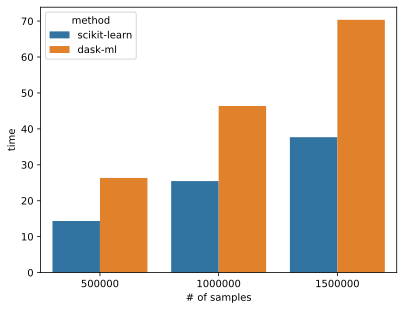

In [6]:
num_sample = [500_000, 1_000_000, 1_500_000]
num_feature = 1_000
timings = []

for n in num_sample:
    X, y = dask_ml.datasets.make_classification(n_samples=n, 
        n_features=num_feature, 
        random_state=42,
        chunks=n // 10
    )
    t1 = time.time()
    sklearn.linear_model.LogisticRegression(solver="lbfgs").fit(X, y)
    timings.append(('scikit-learn', n, time.time() - t1))
    t1 = time.time()
    dask_ml.linear_model.LogisticRegression(solver="lbfgs").fit(X, y)
    timings.append(('dask-ml', n, time.time() - t1))

df = pd.DataFrame(timings, columns=['method', '# of samples', 'time'])
sns.barplot(data=df, x='# of samples', y='time', hue='method')

可见，在逻辑回归这个场景上，比起 scikit-learn，Dask-ML 在单机多核上并无太多优势。而且很多传统机器学习算法对训练数据量的要求没那么高，随着训练数据的增加，传统的机器学习算法的性能不会显著增加。训练数据量和模型性能之间的关系可以通过学习曲线（Learning Curves）来可视化，随着训练数据量增加，像朴素贝叶斯等算法的性能提升十分有限。如果一些机器学习算法无法进行分布式训练或分布式训练成本很高，可以考虑对训练数据采样，数据大小能够放进单机内存，使用 scikit-learn 这种单机框架训练。

综上，如果有一个超出单机内存的训练数据，要根据问题特点、所使用的算法和成本等多方面因素来决定使用何种方式处理。

## XGBoost 和 LightGBM

XGBoost 和 LightGBM 是两种决策树模型的实现，他们本身就对分布式训练友好，且集成了 Dask 的分布式能力。下面以 XGBoost 为例，介绍 XGBoost 如何基于 Dask 实现分布式训练，LightGBM 与之类似。

在 XGBoost 中，训练一个模型既可以使用 `train()` 方法，也可以使用 scikit-learn 式的 `fit()` 方法。这两种方式都支持 Dask 分布式训练。

下面的代码对单机的 XGBoost 和 Dask 分布式训练两种方式进行了性能对比。如果使用 Dask，用户需要将 [`xgboost.DMatrix`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix) 修改为 [`xgboost.dask.DaskDMatrix`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.dask.DaskDMatrix)，`xgboost.dask.DaskDMatrix` 可以将分布式的 Dask Array 或 Dask DataFrame 转化为 XGBoost 所需要的数据格式；用户还需要将 [`xgboost.train()`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.train) 修改为 [`xgboost.dask.train()`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.dask.train)；并传入 Dask 集群客户端 `client`。

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
[22:13:43] task [xgboost.dask-0]:tcp://127.0.0.1:44219 got new rank 0
[22:13:43] task [xgboost.dask-1]:tcp://127.0.0.1:41549 got new rank 1
[22:13:43] task [xgboost.dask-2]:tcp://127.0.0.1:42877 got new rank 2
[22:13:43] task [xgboost.dask-3]:tcp://127.0.0.1:34321 got new rank 3
[22:13:43] task [xgboost.dask-4]:tcp://127.0.0.1:36039 got new rank 4
[22:13:43] task [xgboost.dask-5]:tcp://127.0.0.1:35057 got new rank 5
[22:13:43] task [xgboost.dask-6]:tcp://127.0.0.1:36811 got new rank 6
[22:13:43] task [xgboost.dask-7]:tcp://127.0.0.1:42081 got new rank 7
/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask/base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
[22:16:2

<Axes: xlabel='# of samples', ylabel='time'>

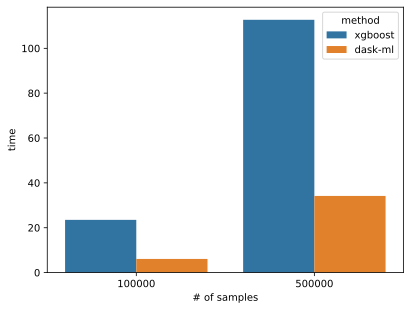

In [11]:
import xgboost as xgb

num_sample = [100_000, 500_000]
num_feature = 1_000
xgb_timings = []

for n in num_sample:
    X, y = dask_ml.datasets.make_classification(n_samples=n, 
        n_features=num_feature, 
        random_state=42,
        chunks=n // 10
    )
    dtrain = xgb.DMatrix(X, y)
    t1 = time.time()
    xgb.train(
        {"tree_method": "hist", "objective": "binary:hinge"},
        dtrain,
        num_boost_round=4,
        evals=[(dtrain, "train")],
        verbose_eval=False,
    )
    xgb_timings.append(('xgboost', n, time.time() - t1))
    dtrain_dask = xgb.dask.DaskDMatrix(client, X, y)
    t1 = time.time()
    xgb.dask.train(
        client,
        {"tree_method": "hist", "objective": "binary:hinge"},
        dtrain_dask,
        num_boost_round=4,
        evals=[(dtrain_dask, "train")],
        verbose_eval=False,
    )
    xgb_timings.append(('dask-ml', n, time.time() - t1))

df = pd.DataFrame(xgb_timings, columns=['method', '# of samples', 'time'])
sns.barplot(data=df, x='# of samples', y='time', hue='method')

如果是 XGBoost 的 scikit-learn 式 API，需要将 [`xgboost.XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) 修改为 [`xgboost.dask.DaskXGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.dask.DaskXGBClassifier) 或者 [`xgboost.XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) 修改为 [`xgboost.dask.DaskXGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)。

### 分布式 GPU 训练

Dask 可以管理多块 GPU，XGBoost 可以基于 Dask 进行多 GPU 训练，我们需要安装 Dask-CUDA 以启动一个多 GPU 的 Dask 集群。Dask 可以将 XGBoost 分布到多张 GPU 卡上进行训练。

In [4]:
from dask_cuda import LocalCUDACluster
import xgboost as xgb
client = Client(LocalCUDACluster())
client

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/distributed/deploy/spec.py:324: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44607 instead
  self.scheduler = cls(**self.scheduler_spec.get("options", {}))


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:44607/status,
Dashboard: http://127.0.0.1:44607/status,Workers: 4
Total threads: 4,Total memory: 90.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33619,Workers: 4
Dashboard: http://127.0.0.1:44607/status,Total threads: 4
Started: Just now,Total memory: 90.00 GiB
Comm: tcp://127.0.0.1:45305,Total threads: 1
Dashboard: http://127.0.0.1:46261/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:37589,


In [9]:
clf = xgb.dask.DaskXGBClassifier(verbosity=1)
clf.set_params(tree_method="hist", device="cuda")
clf.client = client

In [10]:
X, y = dask_ml.datasets.make_classification(n_samples=100_000, 
        n_features=1_000, 
        random_state=42,
        chunks=100_000 // 100
)
clf.fit(X, y, eval_set=[(X, y)], verbose=False)
prediction = clf.predict(X)

/fs/fast/u20200002/envs/dispy/lib/python3.11/site-packages/dask_ml/datasets.py:373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  informative_idx, beta = dask.compute(
[23:01:19] task [xgboost.dask-0]:tcp://127.0.0.1:45305 got new rank 0
[23:01:19] task [xgboost.dask-1]:tcp://127.0.0.1:38835 got new rank 1
[23:01:19] task [xgboost.dask-2]:tcp://127.0.0.1:46315 got new rank 2
[23:01:20] task [xgboost.dask-3]:tcp://127.0.0.1:38331 got new rank 3
